In [1]:
import os
from datetime import datetime, timedelta
from pathlib import Path
from utils.atc_pipeline import RecordingSession, download_archive_audio, download_adsb, transcribe_audio, process_sessions 
from utils.liveatc_utils import get_stations, is_enroute_frequency

from traffic.data import eurofirs, airports

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.7.1+cu126. Bad things might happen unless you revert torch to 1.x.


/home/kruu/git_folder/atc_clearences/.venv/lib/python3.12/site-packages/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.custom_fwd(fwd, cast_inputs=cast_inputs)


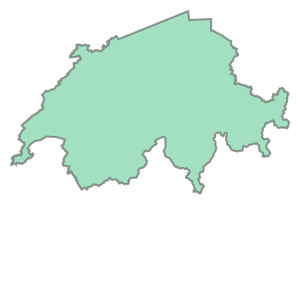

In [24]:
eurofirs["LSAS"]

In [25]:
stations = get_stations("LSZH")

for station in stations:
  # enroute_freqs = [f for f in station['frequencies'] if is_enroute_frequency(f)]
  enroute_freqs = [f for f in station['frequencies']]
  if enroute_freqs and station["up"]:
    print(f"[{station['identifier']}] - {station['title']}")
    for freq in enroute_freqs:
        print(f"\t{freq['title']} - {freq['frequency']}")

[lszh1_app_east] - LSZH Approach (East)
	Zurich Approach (East) - 135.230
[lszh1_app_fin2] - LSZH Approach (Final)
	Zurich Approach (Final) - 125.330
[lszh1_apr_w] - LSZH Apron (North)
	Zurich Apron (North) - 121.855
[lszh1_apr_s] - LSZH Apron (South)
	Zurich Apron (South) - 121.755
[lszh1_atis_arr] - LSZH ATIS (Arrival)
	Zurich Arrival ATIS - 125.730
[lszh1_del] - LSZH Clearance Delivery
	Zurich Clearance Delivery - 121.925
[lszh1_dep] - LSZH Departure
	Zurich Departure - 125.960
[lszh1_gnd] - LSZH Ground
	Zurich Ground - 121.905
[lszh1_rdr_133900] - LSZH Radar East 133.905
	Zurich Radar (Below FL240 East) - 133.905
[lszh1_rdr_133050] - LSZH Radar M1 133.050
	Zurich Radar M1 - 133.050
[lszh1_rdr_133400] - LSZH Radar M2 133.405
	Zurich Radar M2 - 133.405
[lszh1_rdr_132815] - LSZH Radar M3 132.815
	Zurich Radar - 132.815
[lszh1_rdr_134605] - LSZH Radar M4 134.605
	Zurich Radar M4 - 134.605
[lszh1_rdr_132835] - LSZH Radar M5 132.835
	Zurich Radar M5 - 132.835
[lszh1_rdr_133690] - LSZH Ra

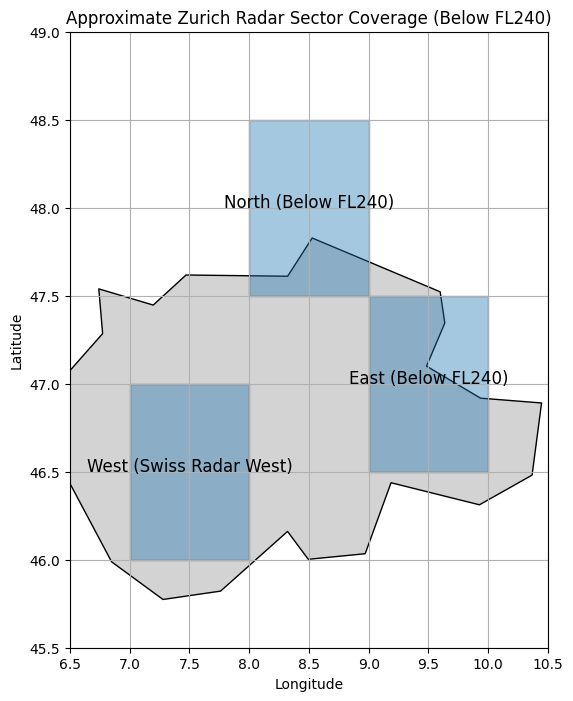

In [31]:
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# Rough polygon definitions (longitude, latitude)
sectors = {
    "East (Below FL240)": Polygon([(9.0, 47.5), (10.0, 47.5), (10.0, 46.5), (9.0, 46.5)]),
    "North (Below FL240)": Polygon([(8.0, 47.5), (9.0, 47.5), (9.0, 48.5), (8.0, 48.5)]),
    "West (Swiss Radar West)": Polygon([(7.0, 47.0), (8.0, 47.0), (8.0, 46.0), (7.0, 46.0)])
}

sector_gdf = gpd.GeoDataFrame(
    [{"sector": name, "geometry": geom} for name, geom in sectors.items()],
    crs="EPSG:4326"
)

world = gpd.read_file("maps/ne_110m_admin_0_countries.shp")
switzerland = world[world["ISO_A3"] == "CHE"]

fig, ax = plt.subplots(figsize=(8, 8))
switzerland.plot(ax=ax, color="lightgrey", edgecolor="black")
sector_gdf.plot(ax=ax, alpha=0.4, edgecolor="black")

for _, row in sector_gdf.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["sector"], ha="center", fontsize=12)

ax.set_title("Approximate Zurich Radar Sector Coverage (Below FL240)")
ax.set_xlim(6.5, 10.5)
ax.set_ylim(45.5, 49.0)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [2]:
session = RecordingSession(
    start_time=datetime(2025, 8, 6, 10, 0),
    end_time=datetime(2025, 8, 6, 10, 30),
    audio_path=Path(),  # placeholder
    artcc="LSAS",
    # airport="ESSL",
    channel="lszh1_rdr_132815",  
)
session = download_archive_audio(session)
session = download_adsb(session)
session = transcribe_audio(session)

[audio] Downloading from https://archive.liveatc.net/lszh/LSZH1-Radar-132815-Aug-06-2025-1000Z.mp3
[audio] Download successful: audio/LSZH1-Radar-132815-Aug-06-2025-1000Z.mp3
[adsb] Ignoring 'half_side_nm' since ARTCC bounds are defined by airspace.bounds
[adsb] Saved 485 records to adsb/LSAS-lszh1_rdr_132815-Aug-06-2025-1000Z.parquet
[vad+spk] Saved chunk 0_0: chunks/LSAS-lszh1_rdr_132815-Aug-06-2025-1000Z/speech_000_00.wav
[vad+spk] Saved chunk 0_1: chunks/LSAS-lszh1_rdr_132815-Aug-06-2025-1000Z/speech_000_01.wav
[vad+spk] Saved chunk 1_0: chunks/LSAS-lszh1_rdr_132815-Aug-06-2025-1000Z/speech_001_00.wav
[vad+spk] Saved chunk 2_0: chunks/LSAS-lszh1_rdr_132815-Aug-06-2025-1000Z/speech_002_00.wav
[vad+spk] Saved chunk 3_0: chunks/LSAS-lszh1_rdr_132815-Aug-06-2025-1000Z/speech_003_00.wav
[vad+spk] Saved chunk 4_0: chunks/LSAS-lszh1_rdr_132815-Aug-06-2025-1000Z/speech_004_00.wav
[vad+spk] Saved chunk 4_1: chunks/LSAS-lszh1_rdr_132815-Aug-06-2025-1000Z/speech_004_01.wav
[vad+spk] Saved chu

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[vad+spk] Saved chunk 120_0: chunks/LSAS-lszh1_rdr_132815-Aug-06-2025-1000Z/speech_120_00.wav
[transcribe] Chunk 1/122: [10:00:17] cleared to proceed lufthansa nine three alfa
[transcribe] Chunk 2/122: [10:00:20] roger we have the climbing speed one zero
[transcribe] Chunk 3/122: [10:00:23] lufthansa nine three alfa ready for takeoff we re level three five zero
[transcribe] Chunk 4/122: [10:00:27] lufthansa three five zero is five zero
[transcribe] Chunk 5/122: [10:00:31] lufthansa nine three alfa request flight level three nine zero
[transcribe] Chunk 6/122: [10:00:38] roger climb to flight level three five zero
[transcribe] Chunk 7/122: [10:00:41] lufthansa nine lima alfa climbing flight level three five zero
[transcribe] Chunk 8/122: [10:00:45] hello swiss two eight six nine lima alfa
[transcribe] Chunk 9/122: [10:00:48] we continue maintaining flight level three two zero
[transcribe] Chunk 10/122: [10:00:50] roger nine lima alfa squawk two seven four seven turn left five six three


In [ ]:
# icao = "EPWA"
# station = "epwa_app"
# start = datetime(2025, 6, 27, 9, 0)
# duration = timedelta(minutes=30)
# nb_periods = 20

# recordings = []
# for i in range(nb_periods):
#     session = RecordingSession(
#             airport=icao,
#             channel=station,
#             start_time=start + i*duration,
#             end_time=start + (i+1)*duration,
#             audio_path=Path()
#         )
#     recordings.append(session)

In [ ]:
# process_sessions(recordings)